In [1]:
# Importing Required Libraries 

# Dataframe Manipulation
import pandas as pd 
import numpy as np 

# Data Visualization
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sn 

# Exploratory Data Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,kpss

# Dealing with warnings 
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Fetch Live Data from nifty 
# Create model 
# Continue fetching the latest results & validate against the model 
# Trigger if Model Retraining is required

### Importing Data
This section deals with importing the complete Nifty50 dataset which contains the valuations from 2000-2021 for more than 50 of the top Indian Multinational Corporations including Cipla, Reliance, Titan ect. We are only going to be dealing with Wipro's valuations, therefore we can perform some filtering to extract the required data.

In [3]:
all_nifty_data = pd.read_csv(r"C:\Users\zzsmathur\Downloads\NIFTY50_all.csv")

# Retrieving Wipro stock data from the entire Nifty dataset
nifty_wipro = all_nifty_data[all_nifty_data["Symbol"]=="WIPRO"].reset_index()
nifty_wipro.drop('index',inplace=True,axis=1)
nifty_wipro.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,WIPRO,EQ,2522.40,2724.00,2724.20,2724.00,2724.20,2724.20,2724.17,1599,4.355942e+11,NaN,NaN,NaN
1,2000-01-04,WIPRO,EQ,2724.20,2942.15,2942.15,2942.15,2942.15,2942.15,2942.15,4392,1.292192e+12,NaN,NaN,NaN
2,2000-01-05,WIPRO,EQ,2942.15,2942.15,3177.55,2715.00,3000.00,2990.10,3063.86,132297,4.053390e+13,NaN,NaN,NaN
3,2000-01-06,WIPRO,EQ,2990.10,3144.70,3183.00,2790.00,2915.00,2932.25,2962.41,72840,2.157822e+13,NaN,NaN,NaN
4,2000-01-07,WIPRO,EQ,2932.25,2751.00,2751.00,2697.70,2697.70,2697.70,2697.95,10110,2.727630e+12,NaN,NaN,NaN


### Exploratory Data Analysis
Now that we have our data, let's familiarize ourselves with it. This section is going to dive deeper into the dataset in order to uncover the underlying patterns and relationships in the data. These relationships can be univariate(single attribute) such as stationarity or multivariate(involving multiple attributes) such cointegration.

<b><u>Workflow of this section:</u></b>

1. Overview of the data
2. Univariate Analysis & Visualization of each time series
3. Checking for Stationarity
4. Decomposition of Time Series

#### 1. Basic Overview
Let's start by knowing a little bit about our data namely, its size,shape,attributes,missing values and some other central tendencies ect.

In [4]:
print(f"Rows: {nifty_wipro.shape[0]}")
print(f"Columns : {nifty_wipro.shape[1]}")

Rows: 5306
Columns : 15


In [5]:
nifty_wipro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4797 non-null   float64
 14  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.9

As expected, most of our variables are numerical in nature. Only 3 attributes store categorical information.

In [6]:
# Both "Symbol" and "Series" store only 1 distinct label, therefore, we can remove these columns during the modelling stage.
print(f"Number of Distinct Labels in Symbol column : {len(nifty_wipro['Symbol'].value_counts())}")
print(f"Number of Distinct Labels in Series column : {len(nifty_wipro['Series'].value_counts())}")

Number of Distinct Labels in Symbol column : 1
Number of Distinct Labels in Series column : 1


In [7]:
# Let's review the numerical columns in the data
nifty_wipro.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.797000e+03,4797.000000
mean,754.857303,756.799981,772.478364,738.150886,754.522418,754.474783,755.165515,2.236123e+06,1.024537e+14,48112.935668,9.957321e+05,0.459096
std,794.521897,803.371567,825.259513,768.613272,794.383479,794.159260,795.825682,4.827183e+06,1.741585e+14,46662.502048,1.324731e+06,0.185192
min,162.350000,163.100000,171.350000,159.400000,161.800000,162.350000,166.440000,1.003000e+03,4.355942e+11,692.000000,8.242000e+03,0.036400
25%,380.525000,380.575000,386.900000,374.475000,380.612500,380.525000,380.480000,6.937025e+05,4.319006e+13,25021.000000,3.023500e+05,0.332100
50%,503.400000,504.000000,510.800000,494.500000,503.800000,503.250000,503.450000,1.152270e+06,6.579357e+13,36659.500000,6.432110e+05,0.483000
75%,679.225000,680.000000,690.887500,670.812500,679.925000,678.687500,680.795000,2.004576e+06,1.075259e+14,55772.750000,1.197829e+06,0.596700
max,9587.450000,10350.000000,10350.000000,8928.350000,9640.000000,9587.450000,9607.140000,1.303677e+08,5.075003e+15,793471.000000,3.554140e+07,0.939400


In [8]:
# Checking missing values 
for idx,column in enumerate(nifty_wipro.columns):
    if ((nifty_wipro[column].isnull().sum()/len(nifty_wipro))*100)> 0:
        print(f"{idx}. {column}------------->{round(((nifty_wipro[column].isnull().sum()/len(nifty_wipro))*100),2)}%")
        
# The missing values in each of these columns will be handled in the preprocessing section

12. Trades------------->53.71%
13. Deliverable Volume------------->9.59%
14. %Deliverble------------->9.59%


### 2. Univariate Analysis
Now that we have a basic idea about our dataset, we can start diving deeper into each attribute and explore the underlying patterns and relationships. This section is all about visualizing our time series and try to find cause and effect relationshps between them. Furthermore, we will break down each time series and study it's components individually. This is performed in order to select a suitable approach for modelling.

In [9]:
# Creating a helper function to visualize each time series from 2000-2022

def visualize_ts(time_series,df,date,xlabel,ylabel,title):
    with sn.axes_style("darkgrid"):
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,5))
        ax = sn.lineplot(data = df, y = time_series , x = pd.to_datetime(df[date]))
        ax.set_title(f'{title}',fontsize=14)
        ax.set_xlabel(f'{xlabel}',fontsize=12)
        ax.set_ylabel(f'{ylabel}',fontsize=12);
        
# Creating a helper function to visualize a time series from start date to an end date

def visualize_ts_dates(df,time_series,start_year,end_year,xlabel,ylabel,title):
    """
    Helper function to visualize a time series between years. 
    Assist in providing a zoomed in view of a time series therby aiding in indentification of trends, turning points.
    """
    start_date = start_year+"-01-01"
    end_date = end_year+"-12-31"
    req_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)
    with sn.axes_style("darkgrid"):
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,5))
        ax = sn.lineplot(data = req_df, y = time_series , x = pd.to_datetime(req_df["Date"]),color="red")
        ax.set_title(f'{title} Between {start_year} and {end_year}',fontsize=14)
        ax.set_xlabel(f'{xlabel}',fontsize=12)
        ax.set_ylabel(f'{ylabel}',fontsize=12);
        
# Creating a helper function to visualize the rolling statistics of a time series on the basis of the window

def plot_rolling_stats(df,time_series,window_size):
    rolling_mean = df[time_series].rolling(window=window_size).mean()
    rolling_std = df[time_series].rolling(window=window_size).std()
    with sn.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(12,5))
        ax.plot(nifty_wipro["VWAP"],label='Original Series',color='Black')
        ax.plot(rolling_mean, color = 'yellow', label = f'Rolling Mean with window {window_size}')
        ax.plot(rolling_std, color = 'red', label = f'Rolling Standard Deviation with window {window_size}')
        ax.legend(loc = 'upper right')
        plt.show()

Since, our objective is to forecast VWAP, let's start with this series

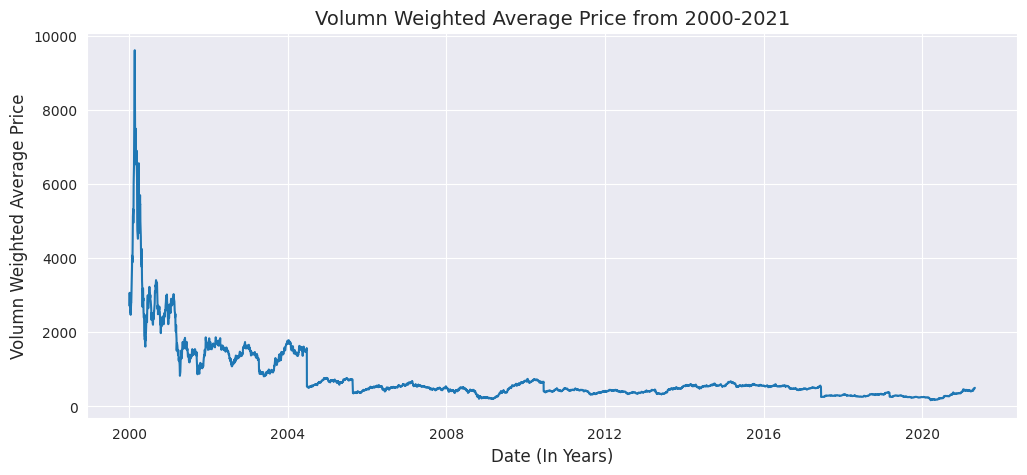

In [10]:
visualize_ts("VWAP",nifty_wipro,"Date",xlabel = "Date (In Years)"
             ,ylabel="Volumn Weighted Average Price",title="Volumn Weighted Average Price from 2000-2021")

From the plot, we can see that there is a tremendous drop in VWAP from 9607.14 (max value in 2000) to just over 501.42 (last recorded observation in the data), which is a decrease of <b>94.8%</b>!The sharp rise and subsequent crash in VWAP is also very evident. Let's zoom into various periods for more insights.

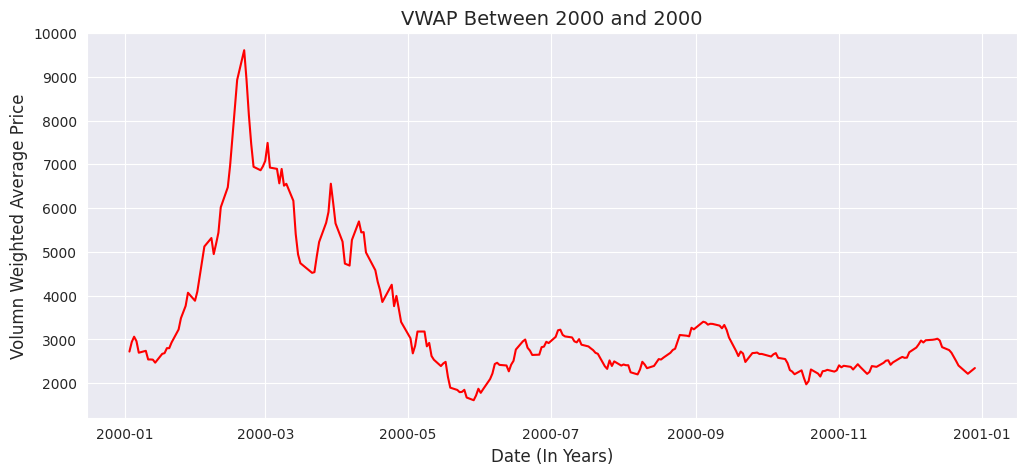

In [11]:
visualize_ts_dates(nifty_wipro,"VWAP","2000","2000",xlabel="Date (In Years)",
                   ylabel="Volumn Weighted Average Price",title="VWAP")

As depicted in the plot, there is a dramatic drop from the Volume Weighted Average Price in 2000 to 2001, subsequently decreasing in the upcoming years. This drop can be attributed to the `dotcom bubble` phenomenon which occured in the stock market in early months of 2000.

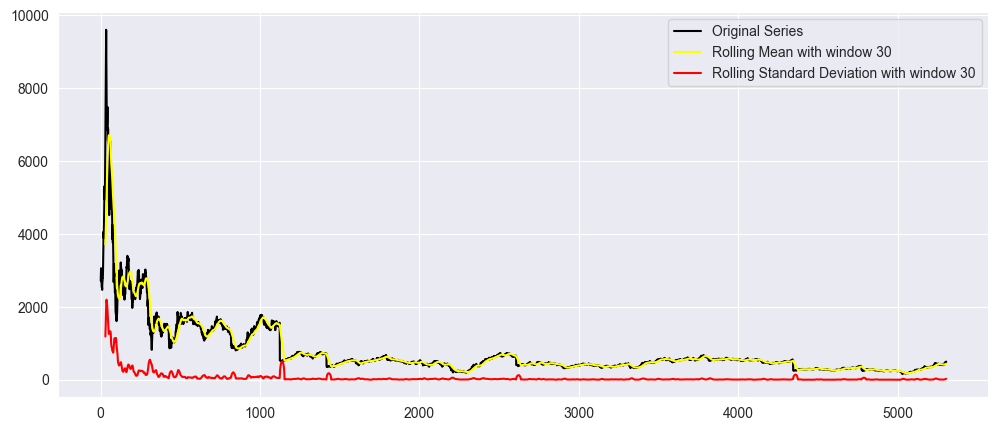

In [12]:
plot_rolling_stats(nifty_wipro,"VWAP",window_size=30)

From the above plot, we can conclude that the assumption of constant mean and constant variance is `not followed` in the time series. This hints at the non-stationarity of the time series, however, let's run some statistical tests to check for stationarity.

Some of the well known tests of stationarity are:

1. Augmnted Dickey Fuller Test
2. KPSS Test
3. Checking Auto Correlation and Partial Auto Correlation plots.

In [13]:
# Creating a helper function to conduct ADF Test on Time Series 
def adf_test(series):
    print("-------- Augmented-Dickey Fuller Test -------------")
    print()
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {result[1]}')
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] >= 0.05 else ""}stationary')

# Creating a helper function to conduct KPSS Test on Time Series 
def kpss_test(series):
    print("---------- KPSS Test ---------------")
    print()
    statistic, p_value, n_lags, critical_values = kpss(series)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
# Creating a helper function to plot Auto Correlation and Partial Auto Correlation of Time Series 
def plot_acf_pacf(series):
    with sn.axes_style("darkgrid"):
        fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
        ax1 = plot_acf(series,ax=ax1, title='Autocorrelation Plot')
        ax2 = plot_pacf(series,ax=ax2, title='Partial Autocorrelation Plot')
        
# Helper function to integrate all the above function into a single function
def check_stationarity(series):
    adf_test(series)
    print("\n")
    kpss_test(series)
    plot_acf_pacf(series)

# Helper function for Time Series Decomposition
def decompose_ts(df,column_name,time_period):
    result = seasonal_decompose((df[column_name]), model='additive', period=time_period)
    with sn.axes_style("darkgrid"):
        fig,ax = plt.subplots(nrows=3,ncols=1, figsize=(15,8))
        ax[0] = sn.lineplot(result.trend,ax=ax[0])
        ax[1] = sn.lineplot(result.seasonal,ax=ax[1])
        ax[2] = sn.lineplot(result.resid,ax=ax[2])

-------- Augmented-Dickey Fuller Test -------------

ADF Statistic: -9.623159990277554
n_lags: 1.6877977706367e-16
p-value: 1.6877977706367e-16
Critial Values:
   1%, -3.4315905168068292
   5%, -2.8620881805547453
   10%, -2.5670617960964766
Result: The series is stationary


---------- KPSS Test ---------------

KPSS Statistic: 5.154704289436489
p-value: 0.01
num lags: 43
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


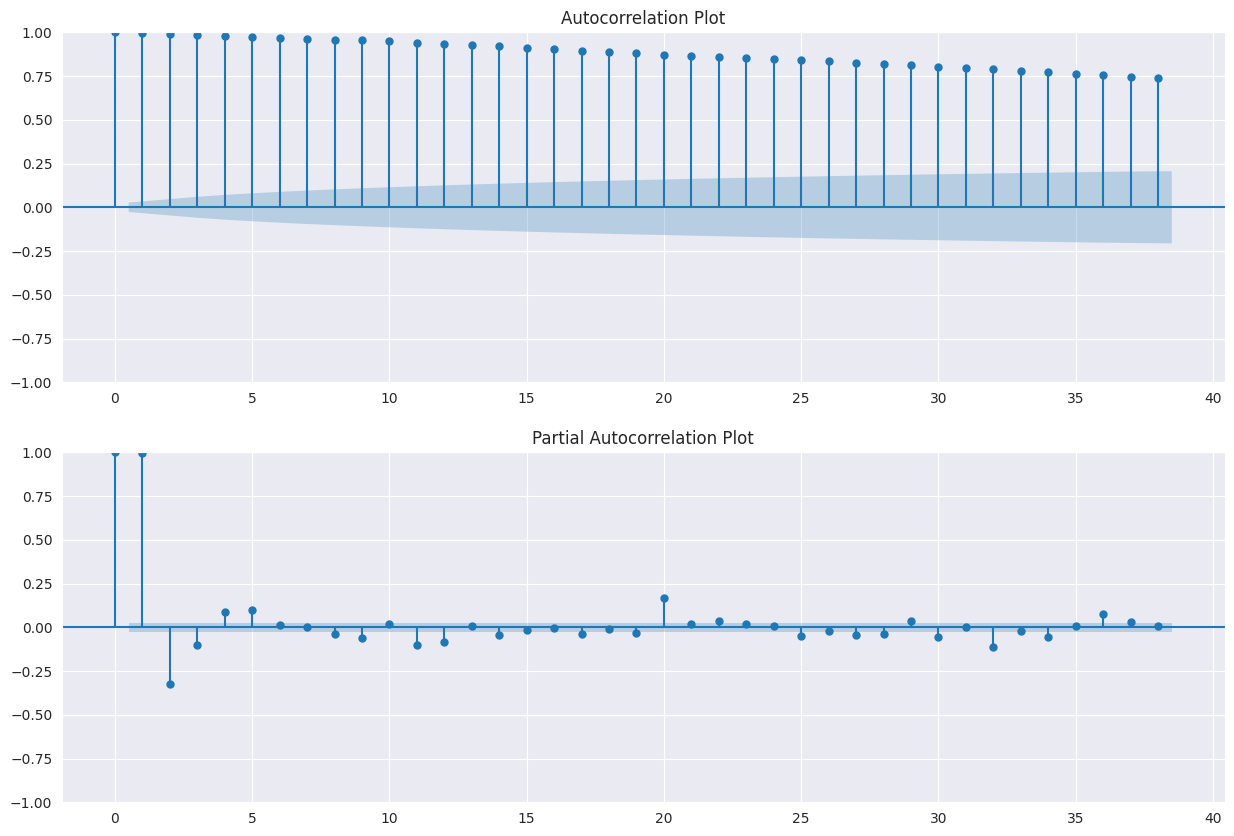

In [14]:
check_stationarity(nifty_wipro["VWAP"])

<u>`Some Observations:`</u>
1. According to the Augmented Dickey Fuller Test, the time series is `stationary`. This means that the time series should have constant mean & variance. However, this hypothesis was dissaproved when the series was plotted. 

2. The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend. According to which, the series is `non-stationary around a deterministic trend`.

3. Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the series is non-stationary, the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends. In the Auto Correlation Plot, there is `high correlation` between t and t+1,t+2 and so on. This means that the present values are heavily affected by the past values.


From these observations, we can conclude that VWAP is `non-stationary`.

<b><u>`Checking Random Walk`</u></b>

Random Walk is a time series behavior model in which the current value of a variable is dependant on the modification of the value of the vairable at t-1 timestep. The value of the variable at the previous time step is added with some random constant, to obtain the value at the current time step.

<b>Identification of Random Walk:</b>

1. Time Series must be Non-Stationarity
2. Gradual Decay in Auto Correlation over lags
3. First Different of the series must be random

From our previous cells, we were able to prove non-stationarity & gradual decay in the autocorrelation in the lags. Let's try verifying the 3rd condition.

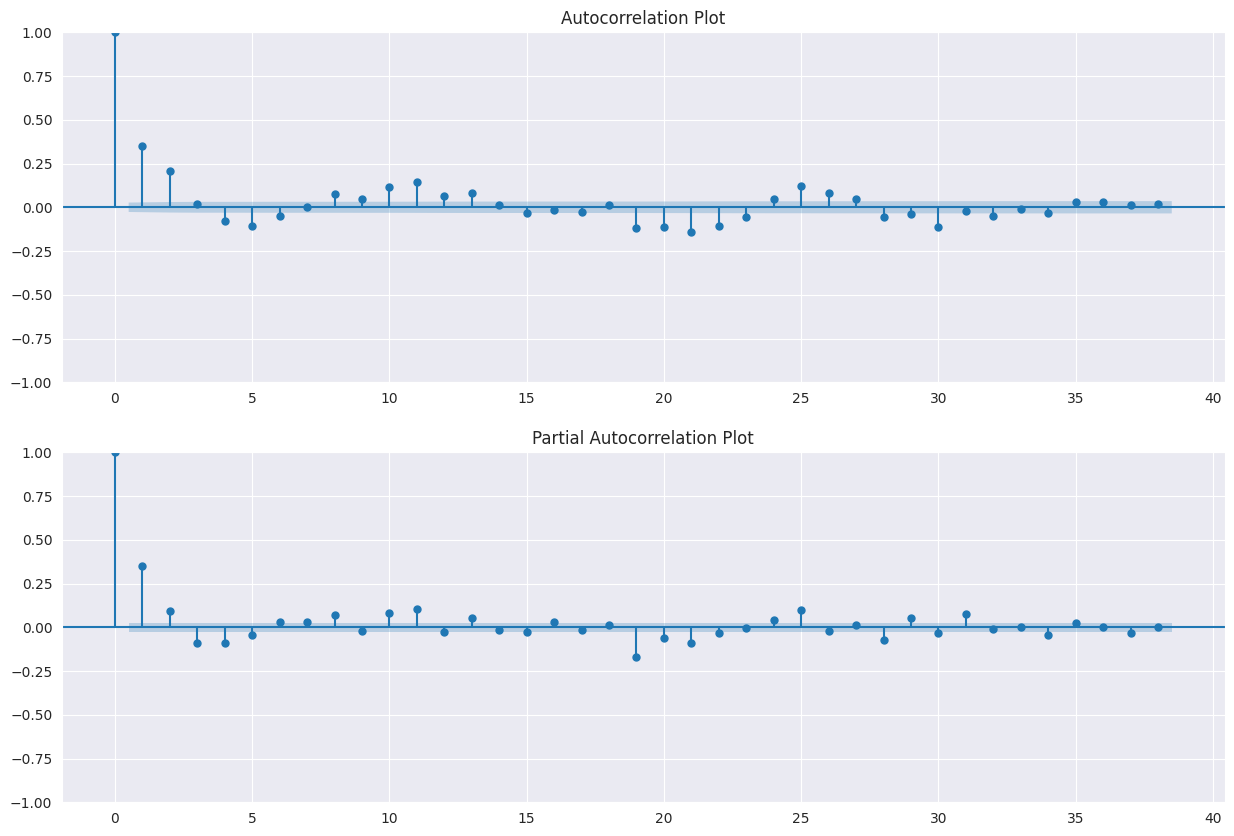

In [15]:
plot_acf_pacf(nifty_wipro["VWAP"].diff().dropna())

The series is definitely `not random` due to the nature of the ACF & PACF Plots. However, the cyclic nature of the decay suggests some seasonality in the series.

### 3. Checking Stationarity

-------- Augmented-Dickey Fuller Test -------------

ADF Statistic: -9.623159990277554
n_lags: 1.6877977706367e-16
p-value: 1.6877977706367e-16
Critial Values:
   1%, -3.4315905168068292
   5%, -2.8620881805547453
   10%, -2.5670617960964766
Result: The series is stationary


---------- KPSS Test ---------------

KPSS Statistic: 5.154704289436489
p-value: 0.01
num lags: 43
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


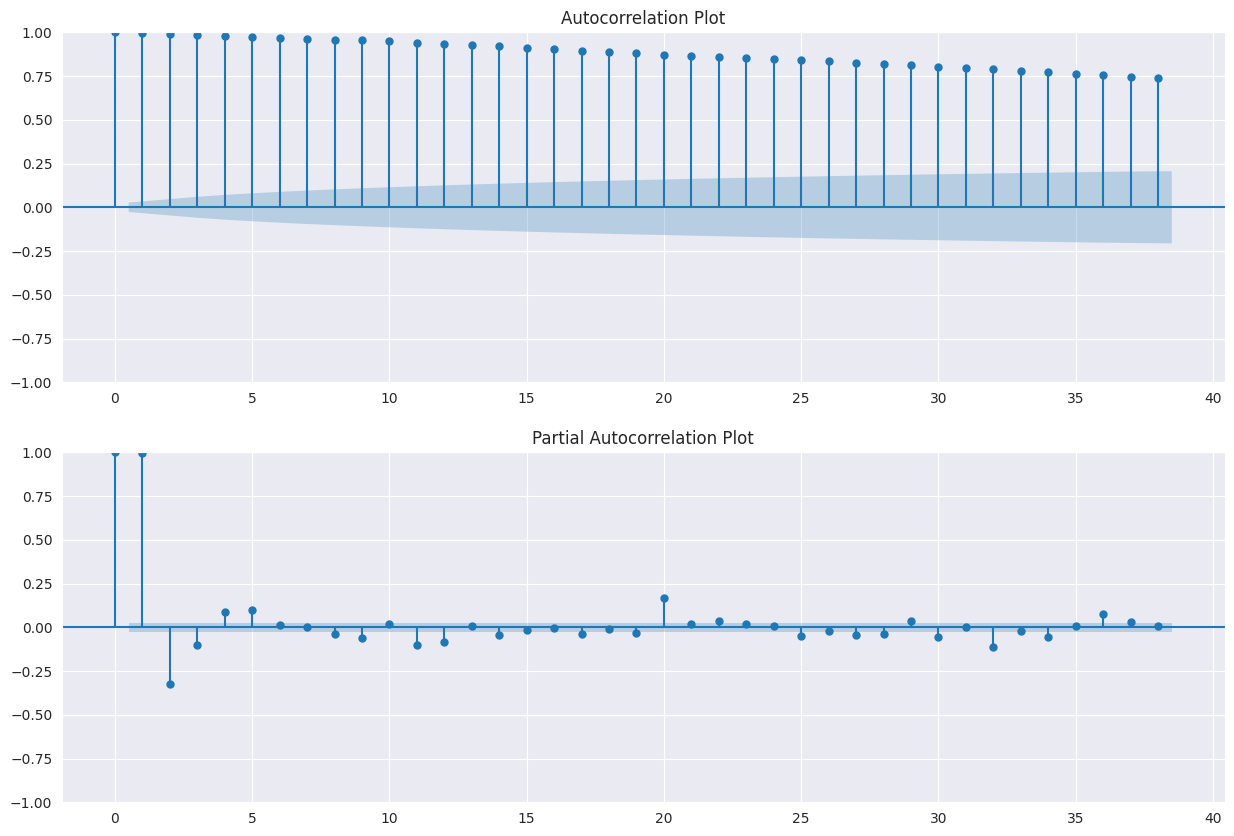

In [16]:
check_stationarity(nifty_wipro["VWAP"])

Although, the ADF Test suggest the time series is stationary, the KPSS tests does not. Furthermore, there is a `cyclic pattern between the significance of lags in the Partial Auto Correlation plot and a slow geometric decay in the ACF plot`. This is generally an indication of heavy seasonality in the variable. We can identify this seasonality by decomposing it into its constituent components.

### 4. Seasonal Decomposition
The nature of the ACF and PACF plots of the target variables, indicates the presence of heavy seasonalities in the variables. This can easily be comfirmed by splitting the variable in its components: Trend, Seasonality, Residuals and Level. I will be using `seasonal_decompose` function of the statsmodels library for decomposition.

In [17]:
# Creating copy of dataset
copy_wipro = nifty_wipro.copy()
copy_wipro['Date'] = pd.to_datetime(copy_wipro['Date'])
copy_wipro = copy_wipro.set_index('Date')

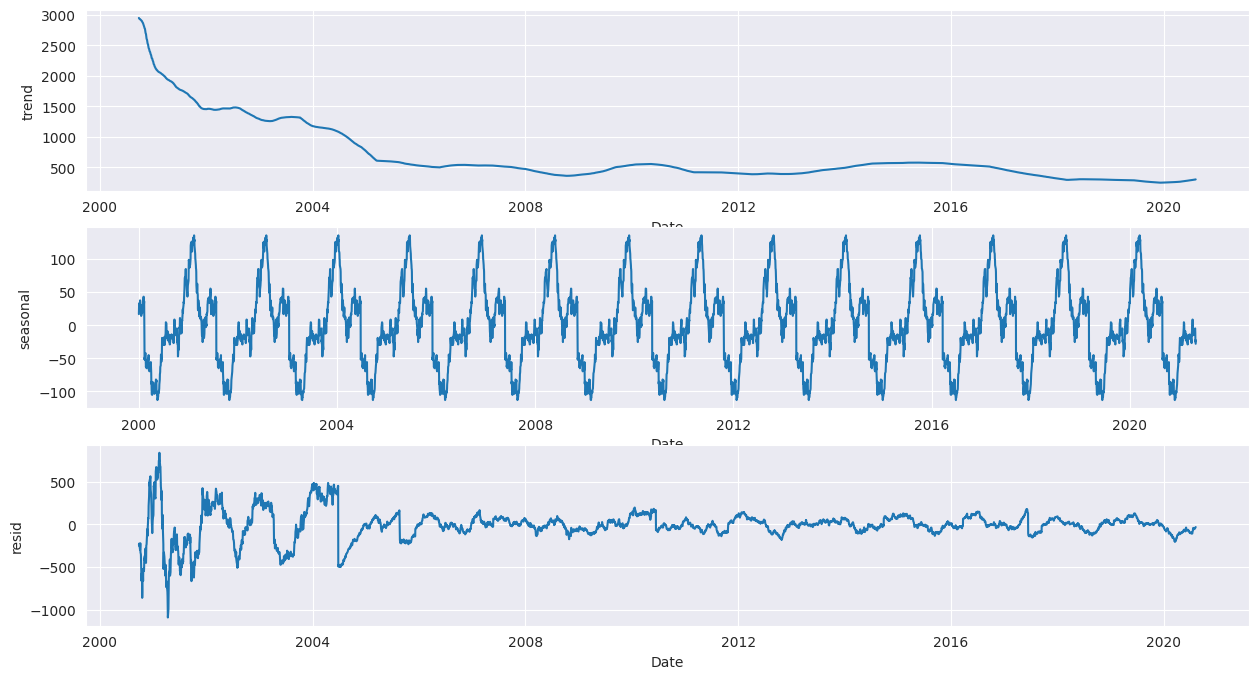

In [18]:
decompose_ts(copy_wipro,"VWAP",365)

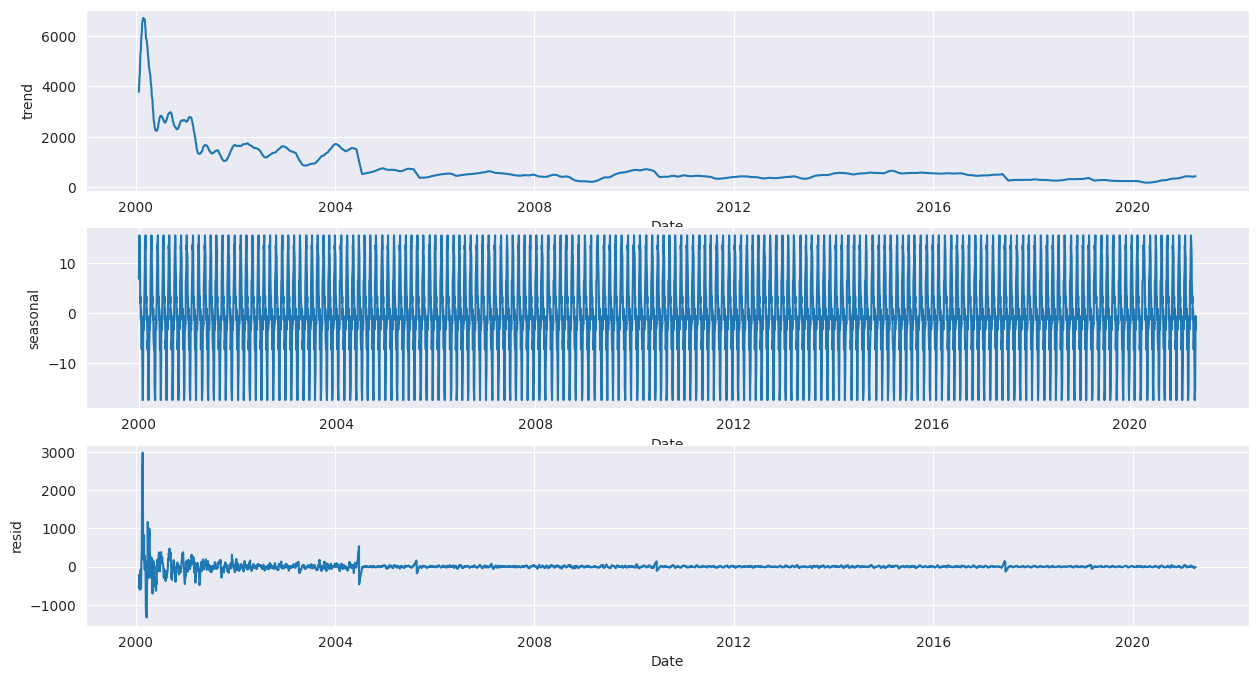

In [19]:
decompose_ts(copy_wipro,"VWAP",30)

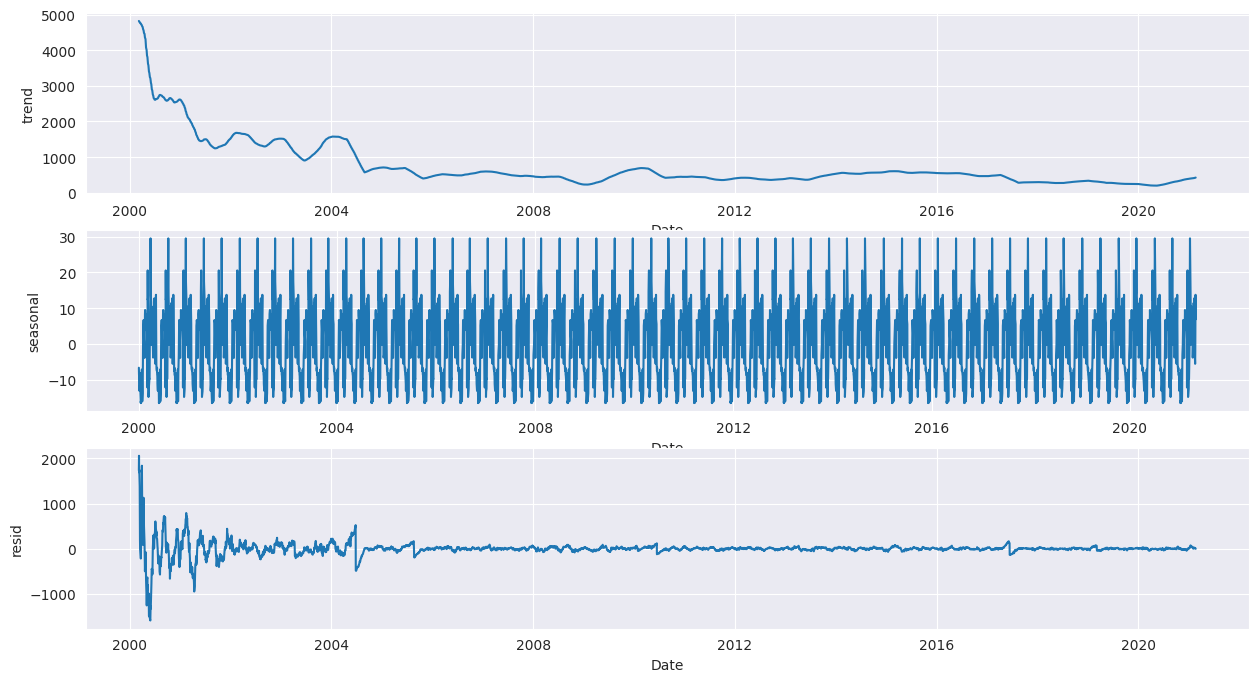

In [20]:
decompose_ts(copy_wipro,"VWAP",90)

From the above cells we have gained a cruicial piece of information about our target variable. 
* Firstly, our target variable follows a decreasing trend over the years. 
* Second, the target contains high amounts of yearly, half-yearly, quaterly, monthly and weekly seasonalities. 

Let's try decomposing other variables to verify if they follow similar patterns of seasonality.

-------- Augmented-Dickey Fuller Test -------------

ADF Statistic: -9.623159990277554
n_lags: 1.6877977706367e-16
p-value: 1.6877977706367e-16
Critial Values:
   1%, -3.4315905168068292
   5%, -2.8620881805547453
   10%, -2.5670617960964766
Result: The series is stationary


---------- KPSS Test ---------------

KPSS Statistic: 5.154704289436489
p-value: 0.01
num lags: 43
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


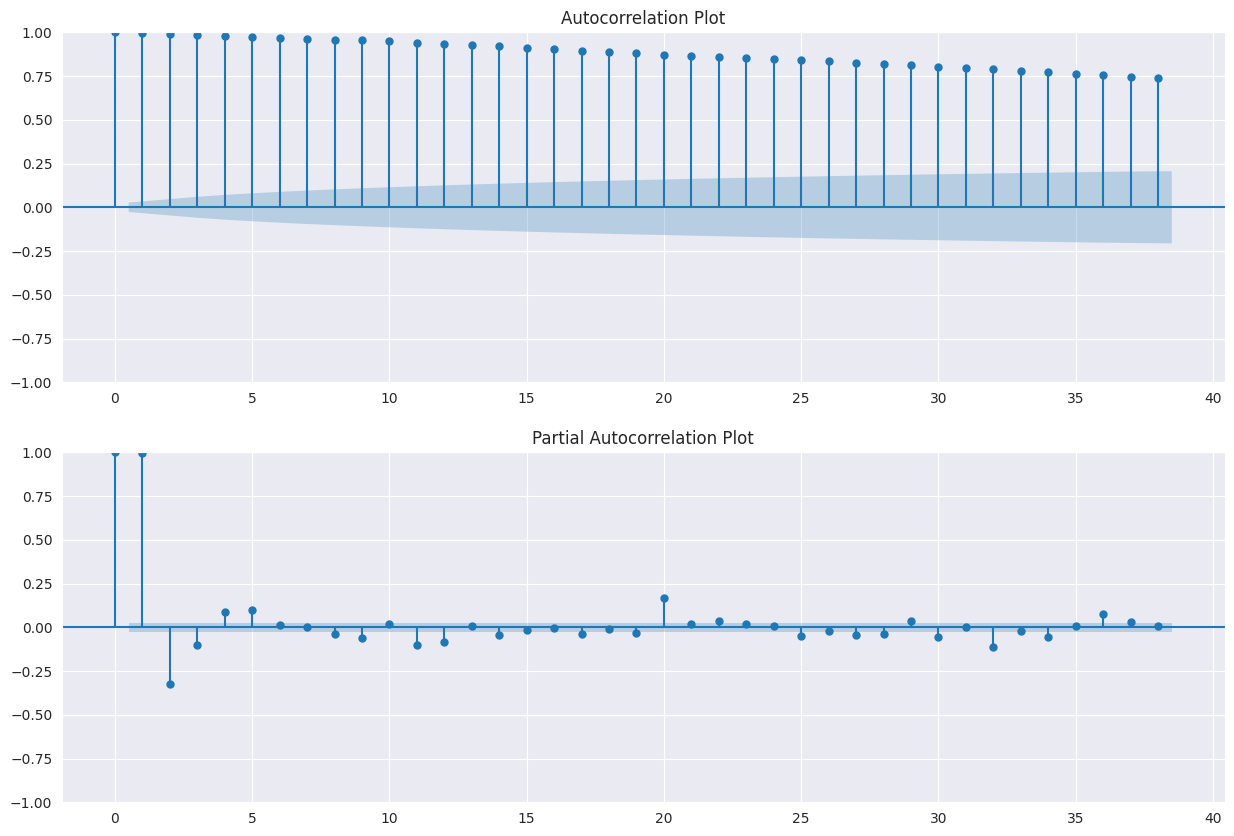

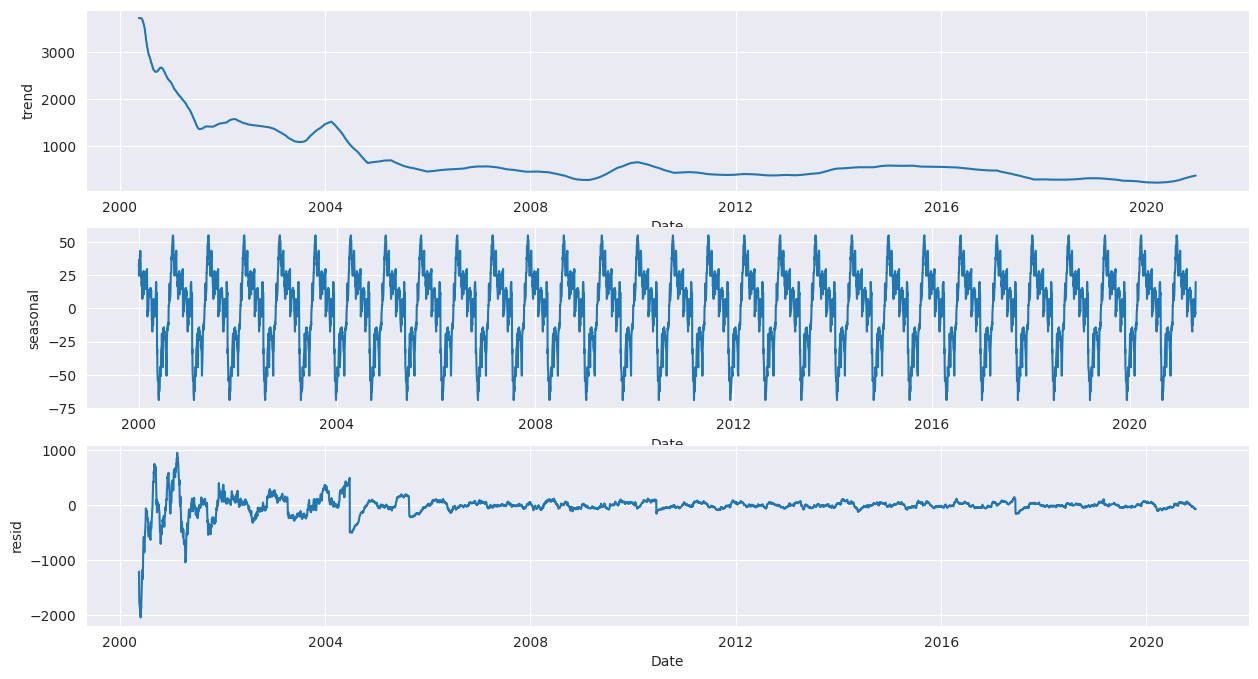

In [21]:
# Checking stationariy & components
check_stationarity(nifty_wipro["VWAP"])
decompose_ts(copy_wipro,"VWAP",180)

-------- Augmented-Dickey Fuller Test -------------

ADF Statistic: -3.2545582596949143
n_lags: 0.017036007163641897
p-value: 0.017036007163641897
Critial Values:
   1%, -3.431590752179765
   5%, -2.8620882845436224
   10%, -2.567061851453409
Result: The series is stationary


---------- KPSS Test ---------------

KPSS Statistic: 4.504794106055122
p-value: 0.01
num lags: 40
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


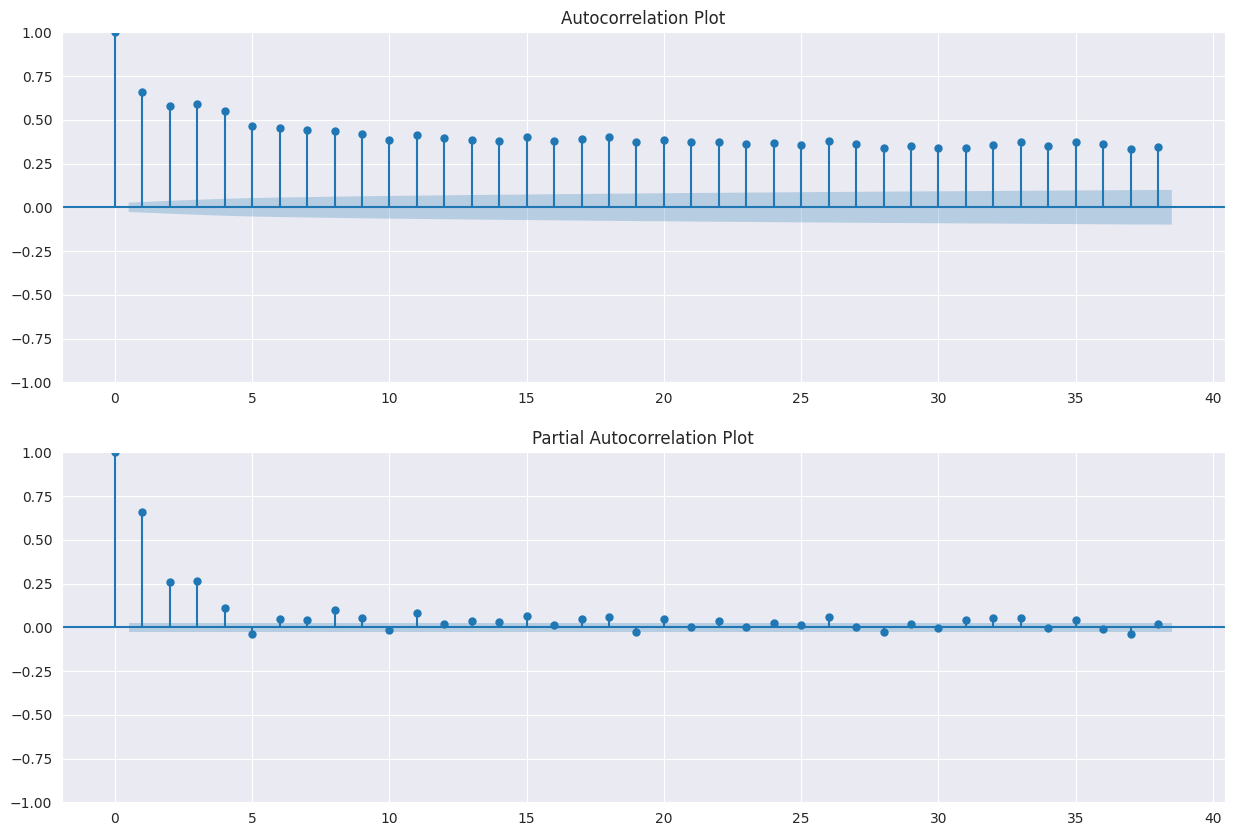

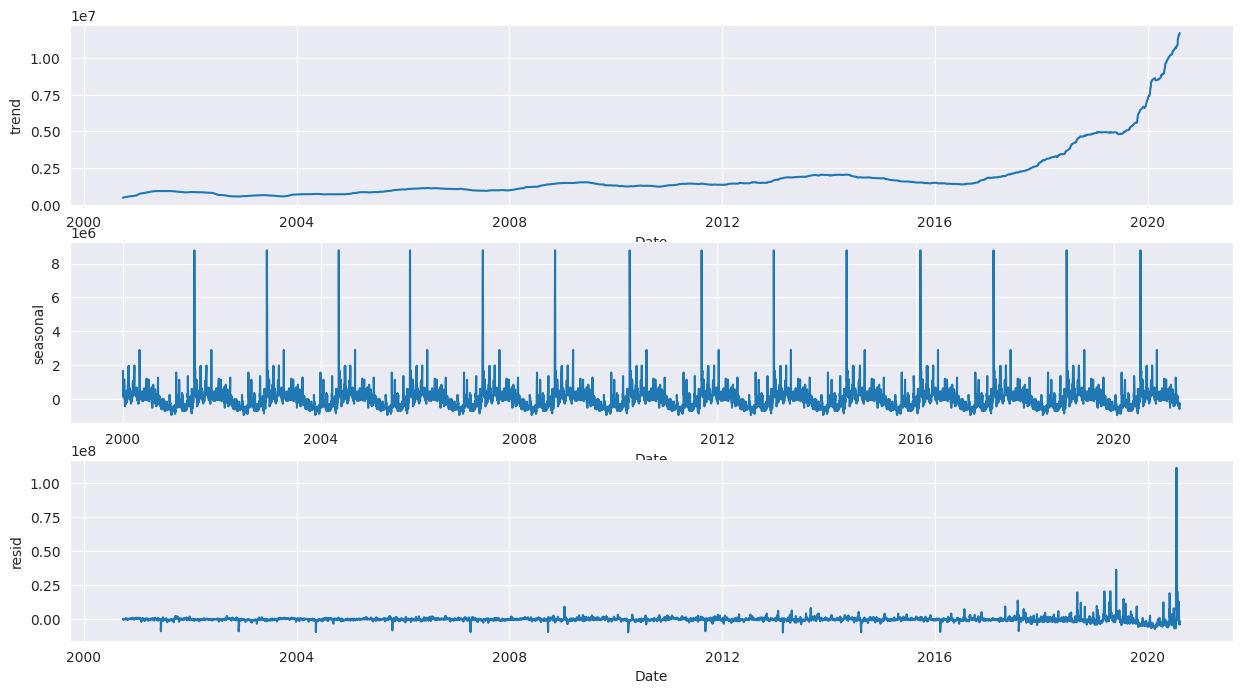

In [22]:
# Checking stationariy & components
check_stationarity(nifty_wipro["Volume"])
decompose_ts(copy_wipro,"Volume",365)

Okay, all of our data follows the similary overall seasonality & trends. In the upcoming sections, we can experiment with various methods to handle seasonality in the data.